# Check normalizations

In order to compare the major element geochemical composition of different samples, researchers generally normalize the major element compositionto a 100% volatile-free basis. Because of the heterogeneity of the data in the BOOM dataset, different major elements have been analyzed for different samples, thus raising the question: are sample observations normalized by different analyitical totals still comparable?

In [1]:
import pandas as pd
import requests
from io import StringIO

#Download the dataset from the ESPRI server as .csv 
url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase.csv"
s=requests.get(url).text
BOOM = pd.read_csv(StringIO(s), encoding="latin1", low_memory=False)

#in case the ESPRI server is down:
#df = pd.read_csv("..assets/Data/BOOMDataset.csv", encoding = 'UTF-8', low_memory =False )

In the dataset, the data was stored as in the original publication. Because of this, in many cases the assigned value to a particular element might not be a number but an expresion to indicate: missingness, lower than a certain value, below detection limit (bdl) or over range. In order to treat the data, these values are replaced by NAN. In order to process the data it is necesary to replace these expressions by "NaN".

In [2]:
import numpy as np

BOOM =BOOM.replace(to_replace=dict.fromkeys(['Over range','bld',
                                                         '<0.01','<0.1','<1','<5','<6','<10',
                                                         'n.a.','Not analyzed','Not Netermined','-', 'n.d.', 'n.d']),value=np.nan)

For evaluating the effect that analyzing different major elements has on their normalization, we are only interested in Sample Observations where major elements have been analyzed:

In [3]:
BOOM_major = BOOM.dropna(subset=['SiO2'],axis=0,how='any')

Now we check the missingness of the different major elements, as we can see, MnO, P2O5 and CL are less routinely analyzed than the rest of the elements.

<AxesSubplot:>

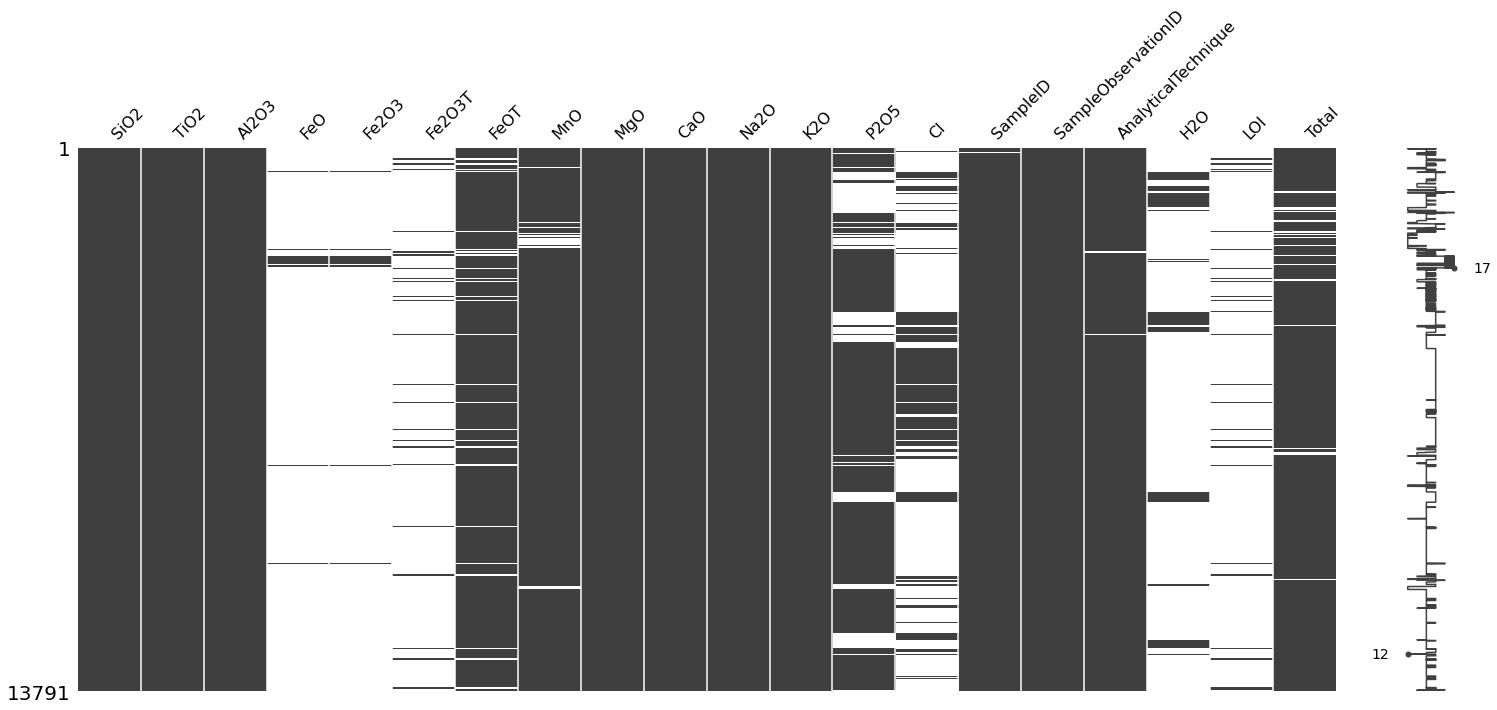

In [4]:
import missingno as msno
msno.matrix(pd.concat([BOOM_major]).loc[:,'SiO2':'Total'])

In order to test the effect that analyzing different major elements has on their normalization, we re-normalize sample observations by a new total:

    new_Total = SiO2 + TiO2 + Al2O3 + MgO + CaO + Na2O + K2O (i.e. without MnO, P2O5 or CL) (1)

and calculate the difference between the normalized values as:

    Δ_major_element = major_element_original - major_element_new_Total (2)

Then, we compare the Δ_major_element with the precision (1 SD) with which the different major elements can be analyzed, which is given by the certified values of the different geostandards analyzed along with the samples. From the comparison (3), the difference in the normalization is smaller than the precision of the different elements, and thus we conclude that sample observations normalized by *different* totals (computed as the sum of *different* major elements), can be compared.  

In [5]:
# (1)
import sys
sys.path.insert(1, '../Scripts')
from functions import renormalizing

BOOM_major = BOOM_major.reset_index(drop = True)
BOOM_major_renormalized= renormalizing(BOOM_major)

In [6]:
BOOM_major_renormalized.loc[:,'SiO2_normalized':'K2O_normalized'].describe()

,SiO2_normalized,TiO2_normalized,Al2O3_normalized,FeO_normalized,Fe2O3_normalized,Fe2O3T_normalized,FeOT_normalized,MnO_normalized,MgO_normalized,CaO_normalized,Na2O_normalized,K2O_normalized
count,13791.000000,13791.000000,13791.000000,407.000000,457.000000,698.000000,12971.000000,12497.000000,13791.000000,13791.000000,13791.000000,13791.000000
mean,64.740497,0.982857,15.370809,7.146027,3.165235,8.426058,5.902079,0.156548,1.959292,4.383731,4.497370,2.066659
std,7.476638,0.581990,1.426570,2.377815,2.074676,2.270091,3.399713,0.158753,1.749219,2.730494,0.876063,0.951617
min,47.918943,0.000000,9.464559,0.290102,0.150053,1.400651,0.135947,-0.041335,0.000000,0.345903,0.754755,0.009026
25%,57.466461,0.511176,14.300210,5.432550,2.224455,6.907889,3.285133,0.104559,0.520165,1.978160,3.812900,1.211512
50%,65.449576,0.959596,15.356096,8.082197,2.350269,8.815169,4.899107,0.151574,1.257062,3.499302,4.553033,1.908419
75%,70.579791,1.379587,16.104810,8.566212,2.996725,10.062990,9.207669,0.193294,3.268751,6.900553,5.159454,2.927708
max,79.767087,6.302076,25.502478,11.566819,10.460000,15.524120,15.311673,4.471731,16.221317,12.035703,7.781000,5.898285


In [7]:
# (2)
# calculate difference between normalized and re-normalized compositions
BOOM_major_renormalized['ΔSiO2'] = np.subtract(BOOM_major_renormalized['SiO2_normalized'],BOOM_major['SiO2_normalized'])
BOOM_major_renormalized['ΔTiO2'] = np.subtract(BOOM_major_renormalized['TiO2_normalized'],BOOM_major['TiO2_normalized'])
BOOM_major_renormalized['ΔAl2O3'] = np.subtract(BOOM_major_renormalized['Al2O3_normalized'],BOOM_major['Al2O3_normalized'])
BOOM_major_renormalized['ΔFeOT'] = np.subtract(BOOM_major_renormalized['FeOT_normalized'],BOOM_major['FeOT_normalized'])
BOOM_major_renormalized['ΔMgO'] = np.subtract(BOOM_major_renormalized['MgO_normalized'],BOOM_major['MgO_normalized'])
BOOM_major_renormalized['ΔCaO'] = np.subtract(BOOM_major_renormalized['CaO_normalized'],BOOM_major['CaO_normalized'])
BOOM_major_renormalized['ΔNa2O'] = np.subtract(BOOM_major_renormalized['Na2O_normalized'],BOOM_major['Na2O_normalized'])
BOOM_major_renormalized['ΔK2O'] = np.subtract(BOOM_major_renormalized['K2O_normalized'],BOOM_major['K2O_normalized'])

# (3)
#load MeasurementRuns file to check the geostandards analyzed along with the samples
standard_url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase_Standards.csv"
s=requests.get(standard_url).text
BOOM_geostandards = pd.read_csv(StringIO(s), encoding="latin1")
BOOM_geostandards.loc[:,'MeasurementRun'] = BOOM_geostandards.loc[:,'MeasurementRun'].astype('str')
BOOM_major_renormalized.loc[:,'MeasurementRun'] = BOOM_major_renormalized.loc[:,'MeasurementRun'].astype('str')

#load the Secondary standards reference values
Standards_ref = pd.read_csv('../assets/Data/Standards_Reference.csv', encoding = 'UTF-8', low_memory =False)
Standards_ref = Standards_ref[Standards_ref.ErrorType.isin(['95%CL','SD'])].copy()

#get which secondary standards where analyzed along with the samples
BOOM_major_renormalized_bulk = BOOM_major_renormalized[BOOM_major_renormalized.TypeOfAnalysis == 'Bulk']
BOOM_major_renormalized_glass = BOOM_major_renormalized[BOOM_major_renormalized.TypeOfAnalysis == 'Micro Analytical']

stds_glass =  BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(BOOM_major_renormalized_glass.MeasurementRun.unique())].Standard.unique()
stds_bulk =  BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(BOOM_major_renormalized_bulk.MeasurementRun.unique())].Standard.unique()
Standards_ref_glass = Standards_ref[Standards_ref.StandardID.isin(stds_glass)]
Standards_ref_bulk = Standards_ref[Standards_ref.StandardID.isin(stds_bulk)]

In [ ]:
# (3) Glass analyses

import plotly.express as px
import plotly.graph_objects as go

elementos = ['SiO2']# ,'TiO2','Al2O3','FeOT','MgO','CaO','Na2O','K2O']

for elemento in elementos: #['SiO2','Al2O3']:
    plot1 = go.Scatter(x=BOOM_major_renormalized_glass[elemento+'_normalized'],
               y=BOOM_major_renormalized_glass['Δ'+elemento],
               mode = 'markers',
               hovertext = 'Sample Observation ID: ' + BOOM_major_renormalized_glass.SampleObservationID.astype('str') + ' '+ 
                       BOOM_major_renormalized_glass.Authors.astype('str') + '; LOI:'+ BOOM_major_renormalized_glass.LOI.astype('str')
                       + '; P2O5:'+ BOOM_major_renormalized_glass.P2O5.astype('str')
                       + '; MnO:'+ BOOM_major_renormalized_glass.MnO.astype('str')
                       + '; Cl:'+ BOOM_major_renormalized_glass.Cl.astype('str')
                       + '; Al2O3:'+ BOOM_major_renormalized_glass.Al2O3.astype('str')
                       ,
               marker = dict(color=BOOM_major_renormalized_glass['MnO + P2O5 + Cl'],showscale = True),
               name = "MnO + P2O5 + Cl")

    plot2 = go.Scatter(x = Standards_ref_glass[elemento],
                  y = Standards_ref_glass['σ_'+elemento],
                  text = Standards_ref_glass.StandardID ,
                  hovertext = 'Secondary standard: ' + Standards_ref_glass.StandardID  , 
                  mode = 'markers+text',
                  textposition = 'top center' ,
                  showlegend = False ,
                  line = {'color': "#3b3b3b"})

    Data = [plot1,plot2]
    layout = go.Layout(xaxis=dict(title=elemento), yaxis=dict(title='Δ'+elemento),
                      legend={'y':1.1, 'x':0.98}, width=600, height=500)# title='Re-normalization variation',
    
    fig = go.Figure(data=Data,layout=layout)
    fig.update_traces(marker = dict(size=11))
    fig.update_layout(font = dict(size=15))
    fig.show()

In [ ]:
# (3.2) Bulk analyses

import plotly.express as px
import plotly.graph_objects as go

elementos = ['SiO2']# ,'TiO2','Al2O3','FeOT','MgO','CaO','Na2O','K2O']

for elemento in elementos: #['SiO2','Al2O3']:
    plot1 = go.Scatter(x=BOOM_major_renormalized_bulk[elemento+'_normalized'],
               y=BOOM_major_renormalized_bulk['Δ'+elemento],
               mode = 'markers',
               hovertext = 'Sample Observation ID: ' + BOOM_major_renormalized_bulk.SampleObservationID.astype('str') + ' '+ 
                       BOOM_major_renormalized_bulk.Authors.astype('str') + '; LOI:'+ BOOM_major_renormalized_bulk.LOI.astype('str')
                       + '; P2O5:'+ BOOM_major_renormalized_bulk.P2O5.astype('str')
                       + '; MnO:'+ BOOM_major_renormalized_bulk.MnO.astype('str')
                       + '; Cl:'+ BOOM_major_renormalized_bulk.Cl.astype('str')
                       + '; Al2O3:'+ BOOM_major_renormalized_bulk.Al2O3.astype('str')
                       ,
               marker = dict(color=BOOM_major_renormalized_bulk['MnO + P2O5 + Cl'],showscale = True),
               name = "MnO + P2O5 + Cl")

    plot2 = go.Scatter(x = Standards_ref_bulk[elemento],
                  y = Standards_ref_bulk['σ_'+elemento],
                  text = Standards_ref_bulk.StandardID ,
                  hovertext = 'Secondary standard: ' + Standards_ref_bulk.StandardID  , 
                  mode = 'markers+text',
                  textposition = 'top center' ,
                  showlegend = False ,
                  line = {'color': "#3b3b3b"})

    Data = [plot1,plot2]
    layout = go.Layout(xaxis=dict(title=elemento), yaxis=dict(title='Δ'+elemento),
                      legend={'y':1.1, 'x':0.98}, width=600, height=500)# title='Re-normalization variation',
    
    fig = go.Figure(data=Data,layout=layout)
    fig.update_traces(marker = dict(size=11))
    fig.update_layout(font = dict(size=15))
    fig.show('png')